<a href="https://colab.research.google.com/github/gitgeek28/Stock-Sentiment-Analysis-Using-Machine-Learning/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***STOCK SENTIMENT ANALYSIS OF APPLE, GOOGLE AND AMAZON***

# **STOCK SENTIMENT ANALYSIS OF APPLE**

In [ ]:
! pip install requests beautifulsoup4 pandas

### *NEWS*

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
final = pd.DataFrame()
for j in range(1,201):
  webpage = requests.get(f'https://markets.businessinsider.com/news/aapl-stock?p={j}&')
  soup = BeautifulSoup(webpage.content, 'lxml')
  company = soup.find_all('div', class_="latest-news__story")
  news = []
  date = []

  for i in company:
    try:
      news.append(i.find('a', class_="news-link").text.strip())
    except:
      news.append(np.nan)
    try:
      date.append(i.find(class_="latest-news__date").text.strip())
    except:
      date.append(np.nan)

  df = pd.DataFrame({'news': news, 'date': date})
  final = pd.concat([final,df], ignore_index=True)

from google.colab import files
from datetime import datetime, timedelta
# Function to convert relative date to absolute date
def convert_to_absolute_date(relative_date):
  if relative_date is not None and isinstance(relative_date, str):  # Check if relative_date is not None and is a string
    if 'd' in relative_date:
      days_ago = int(relative_date.replace(',','').replace('d',''))  # Extract the number of days (remove 'd')
      absolute_date = datetime.now() - timedelta(days=days_ago)  # Compute the absolute date
      return absolute_date.strftime('%Y-%m-%d')  # Format as yyyy-mm-dd
    elif 'h' in relative_date:
      hours_ago = int(relative_date.replace(',','').replace('h',''))  # Extract the number of hours (remove 'h')
      absolute_date = datetime.now() - timedelta(hours=hours_ago)  # Compute the absolute date
      return absolute_date.strftime('%Y-%m-%d')  # Format as yyyy-mm-dd
  return relative_date  # Return the original value if it's not a string or is None

final['date'] = final['date'].apply(convert_to_absolute_date)
print("\nDataFrame after converting dates:")
final.rename(columns={'date': 'Date'}, inplace=True)
print("\nDataFrame after renaming 'date' to 'Date':")

 # Save the DataFrame to CSV
final.to_csv('news.csv', index=False)

# Download the CSV file
files.download('news.csv')


DataFrame after converting dates:

DataFrame after renaming 'date' to 'Date':


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### *STOCK DATA*

In [ ]:
import yfinance as yf
import pandas as pd
from google.colab import files

# Function to fetch stock data
def fetch_stock_data(ticker, period='1mo', interval='1d'):
    """
    Fetch stock data for a given ticker symbol.

    Parameters:
    - ticker: String, the ticker symbol of the stock (e.g., 'AAPL' for Apple Inc.).
    - period: String, the period to fetch data for (e.g., '1d' for 1 day, '1mo' for 1 month).
    - interval: String, the interval between data points (e.g., '1m' for 1 minute, '1d' for 1 day).

    Returns:
    - DataFrame, containing the fetched stock data.
    """
    try:
        # Initialize Ticker object
        stock = yf.Ticker(ticker)

        # Fetch historical market data
        data = stock.history(period=period, interval=interval)

        # Reset index to bring the date column into the DataFrame
        data.reset_index(inplace=True)

        # Convert the 'Date' column to datetime without time
        data['Date'] = pd.to_datetime(data['Date']).dt.date

        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
ticker = 'AAPL'   # Ticker symbol for Apple Inc.
period = '10y'    # Fetch data for the last 10 years
interval = '1d'   # Daily data

# Fetch stock data for Apple Inc.
stock_data = fetch_stock_data(ticker, period=period, interval=interval)

# Convert to DataFrame and save to CSV
if stock_data is not None:
    stock_data_df = pd.DataFrame(stock_data)

    # Save DataFrame to a CSV file
    csv_file_path = f"{ticker}_stock_data.csv"
    stock_data_df.to_csv(csv_file_path, index=False)  # Save without index
    print(f"Stock data saved to {csv_file_path}")

    # Download the CSV file to your local machine
    files.download(csv_file_path)
else:
    print("Failed to fetch stock data.")

Stock data saved to AAPL_stock_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### *SENTIMENT ANALYSIS*

In [ ]:
! pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
df1 = pd.read_csv('news.csv')
df2 = pd.read_csv('AAPL_stock_data.csv')

In [ ]:
# first 4 rows of data for df1
df1.head(4)

,news,Date
0,Rag to Riches: 3 AR Stocks That Could Make Ear...,2024-06-19
1,3 Metaverse Stocks to Buy Now: June 2024,2024-06-19
2,3 Tech Stocks the Market Mispriced (And How Yo...,2024-06-19
3,3 EV Stocks to Buy Now for the Rivian Resurgence,2024-06-19


In [ ]:
# no. of rows and columns
df1.shape

(10000, 2)

In [ ]:
# first 4 rows of df2
df2.head(4)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-06-19,20.436121,20.438336,20.225758,20.340904,142112000,0.0,0.0
1,2014-06-20,20.338684,20.493688,20.128322,20.130537,403592000,0.0,0.0
2,2014-06-23,20.221331,20.287762,20.061899,20.112829,174776000,0.0,0.0
3,2014-06-24,20.095106,20.314325,19.971103,19.991032,156144000,0.0,0.0


In [ ]:
# no. of rows and columns
df2.shape

(2517, 8)

In [ ]:
# merging data sets
merge = df1.merge(df2, how='inner', on='Date')

In [ ]:
merge

,news,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,Apple suspends work on high-end Vision headset...,2024-06-18,217.589996,218.630005,213.000000,214.289993,79943300,0.0,0.0
1,Bubble Trouble: 3 Stocks Ready to Burst Under ...,2024-06-18,217.589996,218.630005,213.000000,214.289993,79943300,0.0,0.0
2,Apple Stops Pay Later Scheme; Unveils Installm...,2024-06-18,217.589996,218.630005,213.000000,214.289993,79943300,0.0,0.0
3,3 Magnificent 7 Stocks to Buy Now: June 2024,2024-06-18,217.589996,218.630005,213.000000,214.289993,79943300,0.0,0.0
4,Forget Nvidia: Why Apple’s AI Bombshell Could ...,2024-06-18,217.589996,218.630005,213.000000,214.289993,79943300,0.0,0.0
...,...,...,...,...,...,...,...,...,...
8764,Christmas Left Too Many Toys Behind in Target’...,2020-01-17,76.931910,77.532731,76.622988,77.530304,137816400,0.0,0.0
8765,'No way' Apple breaking encryption for FBI wou...,2020-01-17,76.931910,77.532731,76.622988,77.530304,137816400,0.0,0.0
8766,7 5G Stocks to Connect Your Portfolio To,2020-01-17,76.931910,77.532731,76.622988,77.530304,137816400,0.0,0.0
8767,Apple Stock Is Getting Too Pricey,2020-01-17,76.931910,77.532731,76.622988,77.530304,137816400,0.0,0.0


In [ ]:
# To get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# To get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
# New columns: subjectivity and polarity
merge['Subjectivity'] = merge['news'].apply(getSubjectivity)
merge['Polarity'] = merge['news'].apply(getPolarity)

In [ ]:
#View new columns
merge.head(4)

,news,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,Apple suspends work on high-end Vision headset...,2024-06-18,217.589996,218.630005,213.0,214.289993,79943300,0.0,0.0,0.000,0.000,0.2500,0.000,0.778,0.222
1,Bubble Trouble: 3 Stocks Ready to Burst Under ...,2024-06-18,217.589996,218.630005,213.0,214.289993,79943300,0.0,0.0,0.675,0.275,-0.0516,0.157,0.698,0.145
2,Apple Stops Pay Later Scheme; Unveils Installm...,2024-06-18,217.589996,218.630005,213.0,214.289993,79943300,0.0,0.0,0.000,0.000,-0.2500,0.300,0.700,0.000
3,3 Magnificent 7 Stocks to Buy Now: June 2024,2024-06-18,217.589996,218.630005,213.0,214.289993,79943300,0.0,0.0,1.000,1.000,0.5994,0.000,0.672,0.328


In [ ]:
# To get sentiment scores
def getSIA(text):
  sia = SentimentIntensityAnalyzer()
  sentiment = sia.polarity_scores(text)
  return sentiment

In [ ]:
# Get the sentiment scores
compound = []
neg = []
neu = []
pos = []
SIA = 0

for i in range(0, len(merge['news'])):
  SIA = getSIA(merge['news'][i])
  compound.append(SIA['compound'])
  neg.append(SIA['neg'])
  neu.append(SIA['neu'])
  pos.append(SIA['pos'])

In [ ]:
# Storing scores in merge data set
merge['Compound'] = compound
merge['Negative'] = neg
merge['Neutral'] = neu
merge['Positive'] = pos

In [ ]:
# Checking our merge data
merge.head(4)

In [ ]:
#Creating list of column
keep_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']
df = merge[keep_columns]
df

In [ ]:
df['Labels'] = (df['Close'].shift(-1) >= df['Close']).astype(int)

# Drop the last row with NaN in 'labels'
df = df.dropna(subset=['Labels'])
df

In [ ]:
#Create feature dataset
x = df
x = np.array(x.drop(['Labels'], axis=1))
#Create the target dataset
y = np.array(df['Labels'])

In [ ]:
#splitting data into 80% training and 20% testing data sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
model = LinearDiscriminantAnalysis().fit(x_train, y_train)

In [ ]:
#Show the model predictions
predictions = model.predict(x_test)
predictions

In [ ]:
y_test

In [ ]:
# Model Metrics
print(classification_report(y_test, predictions))

In [ ]:
#ACCURACY

In [ ]:
# Model Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, predictions))

# Calculate accuracy using the score method
accuracy_score_method = model.score(x_test, y_test)
print("Accuracy using score method:", accuracy_score_method)

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy using accuracy_score:", accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predictions) # Import confusion_matrix
print("Confusion Matrix:\n", conf_matrix)

# Calculate accuracy from confusion matrix
accuracy_from_confusion_matrix = conf_matrix.diagonal().sum() / conf_matrix.sum()
print("Accuracy from confusion matrix:", accuracy_from_confusion_matrix)

In [ ]:
#RECALL

In [ ]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
# Calculate recall
recall = recall_score(y_test, predictions)
print("Recall:", recall)

In [ ]:
#F1-SCORE

In [ ]:
f1 = f1_score(y_test, predictions)
print("F1-score:", f1)

In [ ]:
#ROC CURVE ANALYSIS

In [ ]:
prob_predictions = model.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, prob_predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
#Find buy and sell points according to the sentiment, plot them in a chart and calculate the final portfolio and returns

In [ ]:
# Initialize buy/sell points
df['signal'] = 0
df['signal'][df['Compound'] > 0] = 1  # Buy signal
df['signal'][df['Compound'] < 0] = -1  # Sell signal

# Carry forward the last signal if no signal on the current day
df['position'] = df['signal'].replace(to_replace=0, method='ffill')


In [ ]:
# Initial capital
initial_capital = 10000
shares = 0
capital = initial_capital
portfolio_value = []
trade_results = []

# Iterate through the DataFrame to simulate trading
for index, row in df.iterrows():
    if row['position'] == 1 and shares == 0:  # Buy
        shares = capital / row['Close']
        capital = 0
        buy_price = row['Close']
        trade_results.append(0)
    elif row['position'] == -1 and shares > 0:  # Sell
        capital = shares * row['Close']
        shares = 0
        trade_results[-1] = row['Close'] - buy_price
    portfolio_value.append(capital + shares * row['Close'])

df['portfolio_value'] = portfolio_value

# Calculate returns
df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
final_portfolio_value = df['portfolio_value'].iloc[-1]
total_return = df['cumulative_return'].iloc[-1]

print(df[['Close', 'Compound', 'signal', 'portfolio_value', 'cumulative_return']])
print("Final Portfolio Value: ", final_portfolio_value)
print("Total Return: ", total_return)

In [ ]:
# Plot close prices and portfolio value with buy/sell signals
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['portfolio_value'], label='Portfolio Value', color='green')

# Mark buy/sell signals
buy_signals = df[df['signal'] == 1]
sell_signals = df[df['signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal')

plt.title('Stock Price, Buy/Sell Points and Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Calculate returns
df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
final_portfolio_value = df['portfolio_value'].iloc[-1]
total_return = df['cumulative_return'].iloc[-1]
print("Total Return: ", total_return)

In [ ]:
# Sharpe ratio
risk_free_rate = 0.02  # Example risk-free rate
annualized_return = df['daily_return'].mean() * 252  # Assuming 252 trading days in a year
annualized_volatility = df['daily_return'].std() * np.sqrt(252)
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
print("Sharpe Ratio: ", sharpe_ratio)

Sharpe Ratio:  -0.4738341276353246


In [ ]:
# Maximum drawdown
df['peak'] = df['portfolio_value'].cummax()
df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']
max_drawdown = df['drawdown'].min()
print("Maximum Drawdown: ", max_drawdown)

Maximum Drawdown:  -0.745417904687082


In [ ]:
# Number of trades executed
number_of_trades = len(trade_results)
print("Number of Trades: ", number_of_trades)

Number of Trades:  978


In [ ]:
# Win ratio
win_ratio = len([result for result in trade_results if result > 0]) / len(trade_results) if number_of_trades > 0 else np.nan
print("Win Ratio: ", win_ratio)

Win Ratio:  0.24233128834355827


# **STOCK SENTIMENT ANALYSIS OF GOOGLE**

# *News*

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
final = pd.DataFrame()
for j in range(1,201):
  webpage = requests.get(f'https://markets.businessinsider.com/news/googl-stock?p={j}&')
  soup = BeautifulSoup(webpage.content, 'lxml')
  company = soup.find_all('div', class_="latest-news__story")
  news = []
  date = []

  for i in company:
    try:
      news.append(i.find('a', class_="news-link").text.strip())
    except:
      news.append(np.nan)
    try:
      date.append(i.find(class_="latest-news__date").text.strip())
    except:
      date.append(np.nan)

  df = pd.DataFrame({'news': news, 'date': date})
  final = pd.concat([final,df], ignore_index=True)

from google.colab import files
from datetime import datetime, timedelta
# Function to convert relative date to absolute date
def convert_to_absolute_date(relative_date):
  if relative_date is not None and isinstance(relative_date, str):  # Check if relative_date is not None and is a string
    if 'd' in relative_date:
      days_ago = int(relative_date.replace(',','').replace('d',''))  # Extract the number of days (remove 'd')
      absolute_date = datetime.now() - timedelta(days=days_ago)  # Compute the absolute date
      return absolute_date.strftime('%Y-%m-%d')  # Format as yyyy-mm-dd
    elif 'h' in relative_date:
      hours_ago = int(relative_date.replace(',','').replace('h',''))  # Extract the number of hours (remove 'h')
      absolute_date = datetime.now() - timedelta(hours=hours_ago)  # Compute the absolute date
      return absolute_date.strftime('%Y-%m-%d')  # Format as yyyy-mm-dd
  return relative_date  # Return the original value if it's not a string or is None

final['date'] = final['date'].apply(convert_to_absolute_date)
print("\nDataFrame after converting dates:")
final.rename(columns={'date': 'Date'}, inplace=True)
print("\nDataFrame after renaming 'date' to 'Date':")

 # Save the DataFrame to CSV
final.to_csv('google_news.csv', index=False)


DataFrame after converting dates:

DataFrame after renaming 'date' to 'Date':


## *Stocks Data*

In [ ]:
import yfinance as yf
import pandas as pd
from google.colab import files

# Function to fetch stock data
def fetch_stock_data(ticker, period='1mo', interval='1d'):
    """
    Fetch stock data for a given ticker symbol.

    Parameters:
    - ticker: String, the ticker symbol of the stock (e.g., 'AAPL' for Apple Inc.).
    - period: String, the period to fetch data for (e.g., '1d' for 1 day, '1mo' for 1 month).
    - interval: String, the interval between data points (e.g., '1m' for 1 minute, '1d' for 1 day).

    Returns:
    - DataFrame, containing the fetched stock data.
    """
    try:
        # Initialize Ticker object
        stock = yf.Ticker(ticker)

        # Fetch historical market data
        data = stock.history(period=period, interval=interval)

        # Reset index to bring the date column into the DataFrame
        data.reset_index(inplace=True)

        # Convert the 'Date' column to datetime without time
        data['Date'] = pd.to_datetime(data['Date']).dt.date

        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
ticker = 'GOOG'   # Ticker symbol for Google Inc.
period = '10y'    # Fetch data for the last 10 years
interval = '1d'   # Daily data

# Fetch stock data for Apple Inc.
stock_data = fetch_stock_data(ticker, period=period, interval=interval)

# Convert to DataFrame and save to CSV
if stock_data is not None:
    stock_data_df = pd.DataFrame(stock_data)

    # Save DataFrame to a CSV file
    csv_file_path = f"{ticker}_stock_data.csv"
    stock_data_df.to_csv(csv_file_path, index=False)  # Save without index
    print(f"Stock data saved to {csv_file_path}")

    # Download the CSV file to your local machine
    files.download(csv_file_path)
else:
    print("Failed to fetch stock data.")

Stock data saved to GOOG_stock_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Stock data saved to GOOG_stock_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## *Sentiment Analysis*

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
df1 = pd.read_csv('google_news.csv')
df2 = pd.read_csv('GOOG_stock_data.csv')
merge = df1.merge(df2, how='inner', on='Date')
# To get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# To get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

merge['Subjectivity'] = merge['news'].apply(getSubjectivity)
merge['Polarity'] = merge['news'].apply(getPolarity)

def getSIA(text):
  sia = SentimentIntensityAnalyzer()
  sentiment = sia.polarity_scores(text)
  return sentiment

compound = []
neg = []
neu = []
pos = []
SIA = 0

for i in range(0, len(merge['news'])):
  SIA = getSIA(merge['news'][i])
  compound.append(SIA['compound'])
  neg.append(SIA['neg'])
  neu.append(SIA['neu'])
  pos.append(SIA['pos'])

merge['Compound'] = compound
merge['Negative'] = neg
merge['Neutral'] = neu
merge['Positive'] = pos

#Creating list of column
keep_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']
df = merge[keep_columns]

df['Labels'] = (df['Close'].shift(-1) >= df['Close']).astype(int)

# Drop the last row with NaN in 'labels'
df = df.dropna(subset=['Labels'])

#Create feature dataset
x = df
x = np.array(x.drop(['Labels'], axis=1))
#Create the target dataset
y = np.array(df['Labels'])

#splitting data into 80% training and 20% testing data sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

model = LinearDiscriminantAnalysis().fit(x_train, y_train)

#Show the model predictions
predictions = model.predict(x_test)
predictions

In [ ]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# Model Metrics
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.93      1.00      0.97      1639

    accuracy                           0.93      1754
   macro avg       0.47      0.50      0.48      1754
weighted avg       0.87      0.93      0.90      1754



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.93      1.00      0.97      1639

    accuracy                           0.93      1754
   macro avg       0.47      0.50      0.48      1754
weighted avg       0.87      0.93      0.90      1754

Accuracy using score method: 0.9344355758266819
Accuracy using accuracy_score: 0.9344355758266819
Confusion Matrix:
 [[   0  115]
 [   0 1639]]
Accuracy from confusion matrix: 0.9344355758266819
Recall: 1.0
F1-score: 0.9661066902446213
ROC AUC: 0.6927633498686898


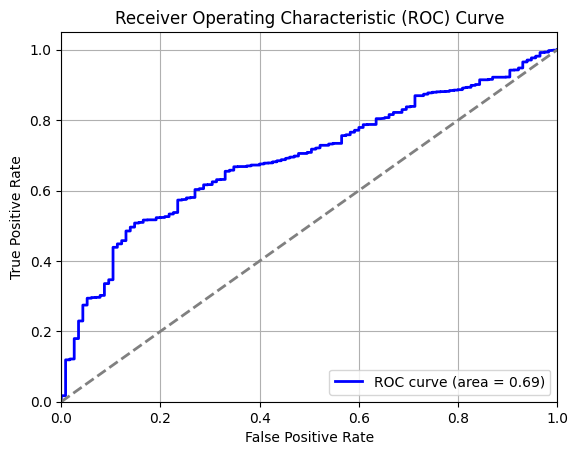

<ipython-input-65-045f04c44cbe>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][df['Compound'] > 0] = 1  # Buy signal
<ipython-input-65-045f04c44cbe>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][df['Compound'] < 0] = -1  # Sell signal


           Close  Compound  signal  portfolio_value  cumulative_return
0     214.289993    0.2500       1     10000.000000           0.000000
1     214.289993   -0.0516      -1     10000.000000           0.000000
2     214.289993   -0.2500      -1     10000.000000           0.000000
3     214.289993    0.5994       1     10000.000000           0.000000
4     214.289993   -0.2263      -1     10000.000000           0.000000
...          ...       ...     ...              ...                ...
8764   77.530304    0.0000       0      3541.072168          -0.645893
8765   77.530304    0.4168       1      3541.072168          -0.645893
8766   77.530304    0.0000       0      3541.072168          -0.645893
8767   77.530304    0.0000       0      3541.072168          -0.645893
8768   77.530304    0.4404       1      3541.072168          -0.645893

[8769 rows x 5 columns]
Final Portfolio Value:  3541.072167917385
Total Return:  -0.6458927832082619


In [ ]:
# Model Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, predictions))

# Calculate accuracy using the score method
accuracy_score_method = model.score(x_test, y_test)
print("Accuracy using score method:", accuracy_score_method)

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy using accuracy_score:", accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predictions) # Import confusion_matrix
print("Confusion Matrix:\n", conf_matrix)

# Calculate accuracy from confusion matrix
accuracy_from_confusion_matrix = conf_matrix.diagonal().sum() / conf_matrix.sum()
print("Accuracy from confusion matrix:", accuracy_from_confusion_matrix)

import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
# Calculate recall
recall = recall_score(y_test, predictions)
print("Recall:", recall)

f1 = f1_score(y_test, predictions)
print("F1-score:", f1)

#ROC CURVE ANALYSIS

prob_predictions = model.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, prob_predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Initialize buy/sell points
df['signal'] = 0
df['signal'][df['Compound'] > 0] = 1  # Buy signal
df['signal'][df['Compound'] < 0] = -1  # Sell signal

# Carry forward the last signal if no signal on the current day
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# Initial capital
initial_capital = 10000
shares = 0
capital = initial_capital
portfolio_value = []
trade_results = []

# Iterate through the DataFrame to simulate trading
for index, row in df.iterrows():
    if row['position'] == 1 and shares == 0:  # Buy
        shares = capital / row['Close']
        capital = 0
        buy_price = row['Close']
        trade_results.append(0)
    elif row['position'] == -1 and shares > 0:  # Sell
        capital = shares * row['Close']
        shares = 0
        trade_results[-1] = row['Close'] - buy_price
    portfolio_value.append(capital + shares * row['Close'])

df['portfolio_value'] = portfolio_value

# Calculate returns
df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
final_portfolio_value = df['portfolio_value'].iloc[-1]
total_return = df['cumulative_return'].iloc[-1]

print(df[['Close', 'Compound', 'signal', 'portfolio_value', 'cumulative_return']])
print("Final Portfolio Value: ", final_portfolio_value)
print("Total Return: ", total_return)

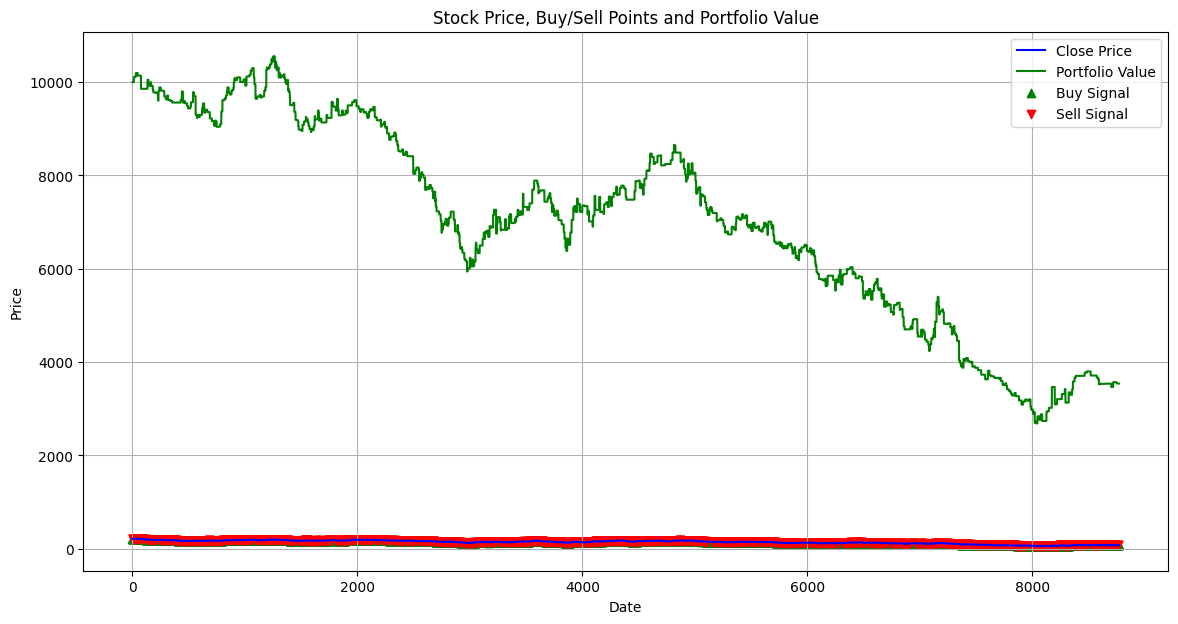

Total Return:  -0.6458927832082619
Sharpe Ratio:  -0.4738341276353246
Maximum Drawdown:  -0.745417904687082
Number of Trades:  978
Win Ratio:  0.24233128834355827


In [ ]:
# Plot close prices and portfolio value with buy/sell signals
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['portfolio_value'], label='Portfolio Value', color='green')

# Mark buy/sell signals
buy_signals = df[df['signal'] == 1]
sell_signals = df[df['signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal')

plt.title('Stock Price, Buy/Sell Points and Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Calculate returns
df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
final_portfolio_value = df['portfolio_value'].iloc[-1]
total_return = df['cumulative_return'].iloc[-1]
print("Total Return: ", total_return)

# Sharpe ratio
risk_free_rate = 0.02  # Example risk-free rate
annualized_return = df['daily_return'].mean() * 252  # Assuming 252 trading days in a year
annualized_volatility = df['daily_return'].std() * np.sqrt(252)
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
print("Sharpe Ratio: ", sharpe_ratio)

# Maximum drawdown
df['peak'] = df['portfolio_value'].cummax()
df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']
max_drawdown = df['drawdown'].min()
print("Maximum Drawdown: ", max_drawdown)

# Number of trades executed
number_of_trades = len(trade_results)
print("Number of Trades: ", number_of_trades)

# Win ratio
win_ratio = len([result for result in trade_results if result > 0]) / len(trade_results) if number_of_trades > 0 else np.nan
print("Win Ratio: ", win_ratio)

# **STOCK SENTIMENT ANALYSIS OF AMAZON**

## *NEWS*

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
final = pd.DataFrame()
for j in range(1,201):
  webpage = requests.get(f'https://markets.businessinsider.com/news/amzn-stock?p={j}&')
  soup = BeautifulSoup(webpage.content, 'lxml')
  company = soup.find_all('div', class_="latest-news__story")
  news = []
  date = []

  for i in company:
    try:
      news.append(i.find('a', class_="news-link").text.strip())
    except:
      news.append(np.nan)
    try:
      date.append(i.find(class_="latest-news__date").text.strip())
    except:
      date.append(np.nan)

  df = pd.DataFrame({'news': news, 'date': date})
  final = pd.concat([final,df], ignore_index=True)

from google.colab import files
from datetime import datetime, timedelta
# Function to convert relative date to absolute date
def convert_to_absolute_date(relative_date):
  if relative_date is not None and isinstance(relative_date, str):  # Check if relative_date is not None and is a string
    if 'd' in relative_date:
      days_ago = int(relative_date.replace(',','').replace('d',''))  # Extract the number of days (remove 'd')
      absolute_date = datetime.now() - timedelta(days=days_ago)  # Compute the absolute date
      return absolute_date.strftime('%Y-%m-%d')  # Format as yyyy-mm-dd
    elif 'h' in relative_date:
      hours_ago = int(relative_date.replace(',','').replace('h',''))  # Extract the number of hours (remove 'h')
      absolute_date = datetime.now() - timedelta(hours=hours_ago)  # Compute the absolute date
      return absolute_date.strftime('%Y-%m-%d')  # Format as yyyy-mm-dd
  return relative_date  # Return the original value if it's not a string or is None

final['date'] = final['date'].apply(convert_to_absolute_date)
print("\nDataFrame after converting dates:")
final.rename(columns={'date': 'Date'}, inplace=True)
print("\nDataFrame after renaming 'date' to 'Date':")

 # Save the DataFrame to CSV
final.to_csv('amazon_news.csv', index=False)


DataFrame after converting dates:

DataFrame after renaming 'date' to 'Date':


## *STOCK DATA*

In [ ]:
import yfinance as yf
import pandas as pd
from google.colab import files

# Function to fetch stock data
def fetch_stock_data(ticker, period='1mo', interval='1d'):
    """
    Fetch stock data for a given ticker symbol.

    Parameters:
    - ticker: String, the ticker symbol of the stock (e.g., 'AAPL' for Apple Inc.).
    - period: String, the period to fetch data for (e.g., '1d' for 1 day, '1mo' for 1 month).
    - interval: String, the interval between data points (e.g., '1m' for 1 minute, '1d' for 1 day).

    Returns:
    - DataFrame, containing the fetched stock data.
    """
    try:
        # Initialize Ticker object
        stock = yf.Ticker(ticker)

        # Fetch historical market data
        data = stock.history(period=period, interval=interval)

        # Reset index to bring the date column into the DataFrame
        data.reset_index(inplace=True)

        # Convert the 'Date' column to datetime without time
        data['Date'] = pd.to_datetime(data['Date']).dt.date

        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
ticker = 'AMZN'   # Ticker symbol for Amazon
period = '10y'    # Fetch data for the last 10 years
interval = '1d'   # Daily data

# Fetch stock data for Apple Inc.
stock_data = fetch_stock_data(ticker, period=period, interval=interval)

# Convert to DataFrame and save to CSV
if stock_data is not None:
    stock_data_df = pd.DataFrame(stock_data)

    # Save DataFrame to a CSV file
    csv_file_path = f"{ticker}_stock_data.csv"
    stock_data_df.to_csv(csv_file_path, index=False)  # Save without index
    print(f"Stock data saved to {csv_file_path}")

    # Download the CSV file to your local machine
    files.download(csv_file_path)
else:
    print("Failed to fetch stock data.")

Stock data saved to AMZN_stock_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## *SENTIMENT ANALYSIS*

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
df1 = pd.read_csv('amazon_news.csv')
df2 = pd.read_csv('AMZN_stock_data.csv')
merge = df1.merge(df2, how='inner', on='Date')
# To get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# To get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

merge['Subjectivity'] = merge['news'].apply(getSubjectivity)
merge['Polarity'] = merge['news'].apply(getPolarity)

def getSIA(text):
  sia = SentimentIntensityAnalyzer()
  sentiment = sia.polarity_scores(text)
  return sentiment

compound = []
neg = []
neu = []
pos = []
SIA = 0

for i in range(0, len(merge['news'])):
  SIA = getSIA(merge['news'][i])
  compound.append(SIA['compound'])
  neg.append(SIA['neg'])
  neu.append(SIA['neu'])
  pos.append(SIA['pos'])

merge['Compound'] = compound
merge['Negative'] = neg
merge['Neutral'] = neu
merge['Positive'] = pos

#Creating list of column
keep_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']
df = merge[keep_columns]

df['Labels'] = (df['Close'].shift(-1) >= df['Close']).astype(int)

# Drop the last row with NaN in 'labels'
df = df.dropna(subset=['Labels'])

#Create feature dataset
x = df
x = np.array(x.drop(['Labels'], axis=1))
#Create the target dataset
y = np.array(df['Labels'])

#splitting data into 80% training and 20% testing data sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

model = LinearDiscriminantAnalysis().fit(x_train, y_train)

#Show the model predictions
predictions = model.predict(x_test)
predictions

<ipython-input-72-aca940995ea3>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Labels'] = (df['Close'].shift(-1) >= df['Close']).astype(int)


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
y_test
# Model Metrics
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.93      1.00      0.97      1639

    accuracy                           0.93      1754
   macro avg       0.47      0.50      0.48      1754
weighted avg       0.87      0.93      0.90      1754



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.94      1.00      0.97      1656

    accuracy                           0.94      1753
   macro avg       0.47      0.50      0.49      1753
weighted avg       0.89      0.94      0.92      1753

Accuracy using score method: 0.9446662863662293
Accuracy using accuracy_score: 0.9446662863662293
Confusion Matrix:
 [[   0   97]
 [   0 1656]]
Accuracy from confusion matrix: 0.9446662863662293
Recall: 1.0
F1-score: 0.9715459078908771
ROC AUC: 0.7201429354051496


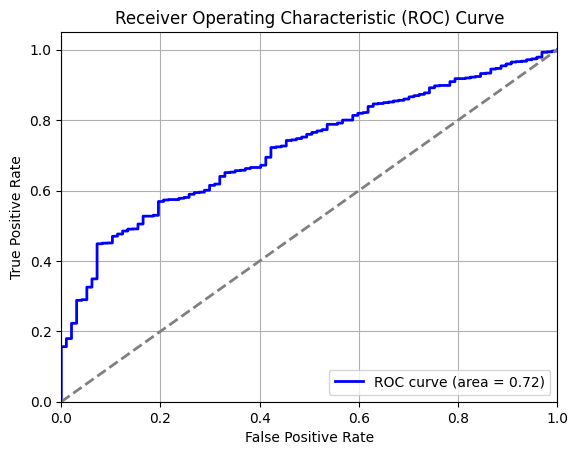

<ipython-input-73-045f04c44cbe>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][df['Compound'] > 0] = 1  # Buy signal
<ipython-input-73-045f04c44cbe>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][df['Compound'] < 0] = -1  # Sell signal


           Close  Compound  signal  portfolio_value  cumulative_return
0     182.809998    0.7269       1     10000.000000           0.000000
1     182.809998    0.3818       1     10000.000000           0.000000
2     182.809998    0.0000       0     10000.000000           0.000000
3     182.809998    0.2023       1     10000.000000           0.000000
4     182.809998   -0.0772      -1     10000.000000           0.000000
...          ...       ...     ...              ...                ...
8760  164.332504    0.3400       1      5194.555202          -0.480544
8761  164.332504    0.7783       1      5194.555202          -0.480544
8762  164.332504    0.0000       0      5194.555202          -0.480544
8763  164.332504    0.0000       0      5194.555202          -0.480544
8764  159.527496   -0.1779      -1      5042.668762          -0.495733

[8765 rows x 5 columns]
Final Portfolio Value:  5042.668762156482
Total Return:  -0.4957331237843511


In [ ]:
# Model Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, predictions))

# Calculate accuracy using the score method
accuracy_score_method = model.score(x_test, y_test)
print("Accuracy using score method:", accuracy_score_method)

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy using accuracy_score:", accuracy)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predictions) # Import confusion_matrix
print("Confusion Matrix:\n", conf_matrix)

# Calculate accuracy from confusion matrix
accuracy_from_confusion_matrix = conf_matrix.diagonal().sum() / conf_matrix.sum()
print("Accuracy from confusion matrix:", accuracy_from_confusion_matrix)

import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
# Calculate recall
recall = recall_score(y_test, predictions)
print("Recall:", recall)

f1 = f1_score(y_test, predictions)
print("F1-score:", f1)

#ROC CURVE ANALYSIS

prob_predictions = model.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, prob_predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Initialize buy/sell points
df['signal'] = 0
df['signal'][df['Compound'] > 0] = 1  # Buy signal
df['signal'][df['Compound'] < 0] = -1  # Sell signal

# Carry forward the last signal if no signal on the current day
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

# Initial capital
initial_capital = 10000
shares = 0
capital = initial_capital
portfolio_value = []
trade_results = []

# Iterate through the DataFrame to simulate trading
for index, row in df.iterrows():
    if row['position'] == 1 and shares == 0:  # Buy
        shares = capital / row['Close']
        capital = 0
        buy_price = row['Close']
        trade_results.append(0)
    elif row['position'] == -1 and shares > 0:  # Sell
        capital = shares * row['Close']
        shares = 0
        trade_results[-1] = row['Close'] - buy_price
    portfolio_value.append(capital + shares * row['Close'])

df['portfolio_value'] = portfolio_value

# Calculate returns
df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
final_portfolio_value = df['portfolio_value'].iloc[-1]
total_return = df['cumulative_return'].iloc[-1]

print(df[['Close', 'Compound', 'signal', 'portfolio_value', 'cumulative_return']])
print("Final Portfolio Value: ", final_portfolio_value)
print("Total Return: ", total_return)

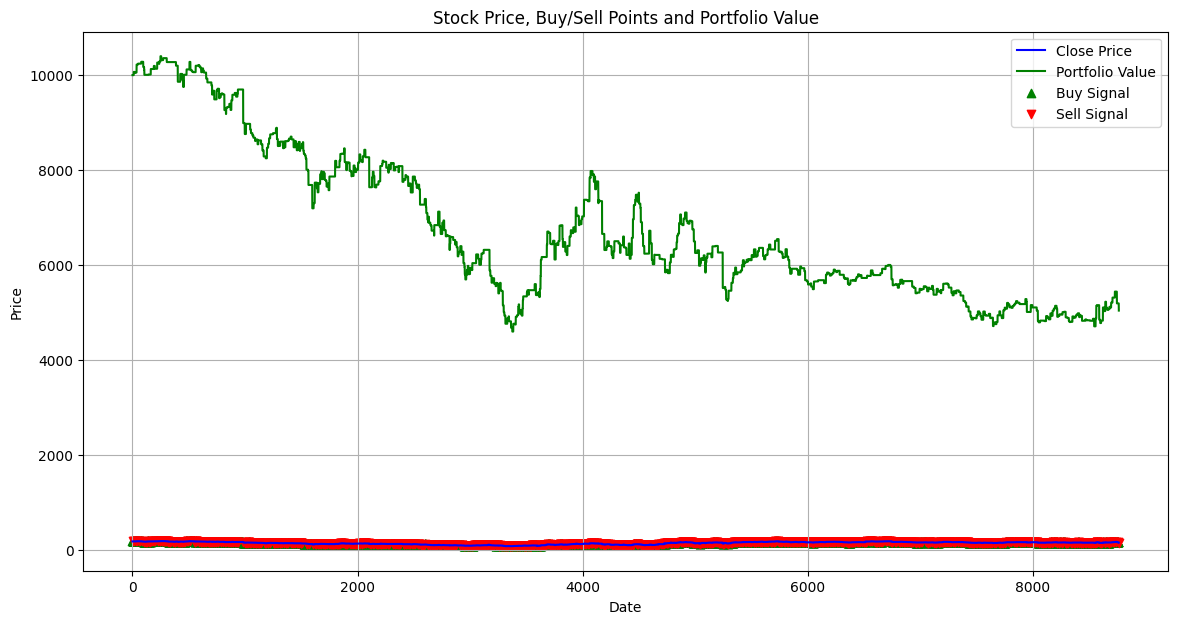

Total Return:  -0.4957331237843511
Sharpe Ratio:  -0.3621838645926704
Maximum Drawdown:  -0.5574829179351318
Number of Trades:  1028
Win Ratio:  0.2490272373540856


In [ ]:
# Plot close prices and portfolio value with buy/sell signals
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['portfolio_value'], label='Portfolio Value', color='green')

# Mark buy/sell signals
buy_signals = df[df['signal'] == 1]
sell_signals = df[df['signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal')

plt.title('Stock Price, Buy/Sell Points and Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

# Calculate returns
df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
df['cumulative_return'] = (1 + df['daily_return']).cumprod() - 1
final_portfolio_value = df['portfolio_value'].iloc[-1]
total_return = df['cumulative_return'].iloc[-1]
print("Total Return: ", total_return)

# Sharpe ratio
risk_free_rate = 0.02  # Example risk-free rate
annualized_return = df['daily_return'].mean() * 252  # Assuming 252 trading days in a year
annualized_volatility = df['daily_return'].std() * np.sqrt(252)
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
print("Sharpe Ratio: ", sharpe_ratio)

# Maximum drawdown
df['peak'] = df['portfolio_value'].cummax()
df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']
max_drawdown = df['drawdown'].min()
print("Maximum Drawdown: ", max_drawdown)

# Number of trades executed
number_of_trades = len(trade_results)
print("Number of Trades: ", number_of_trades)

# Win ratio
win_ratio = len([result for result in trade_results if result > 0]) / len(trade_results) if number_of_trades > 0 else np.nan
print("Win Ratio: ", win_ratio)